# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.metrics import accuracy_score
import optuna
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

#  Exploratory Data Analysis

***Load the datasets***

In [2]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')

**information about the datasets**

In [3]:
train_data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


**summary statistics**

In [4]:
summary_statistics = train_data.describe().style.background_gradient(cmap='viridis')
display(summary_statistics)


,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.500000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.462780,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.000000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.250000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.500000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.750000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.000000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


**Check for missing values**



In [5]:
total_null_values = train_data.isnull().sum().sum()
print(f"Total number of null values in the dataset: {total_null_values}")


Total number of null values in the dataset: 0


#  Data visualization

**distribution of the target variable**

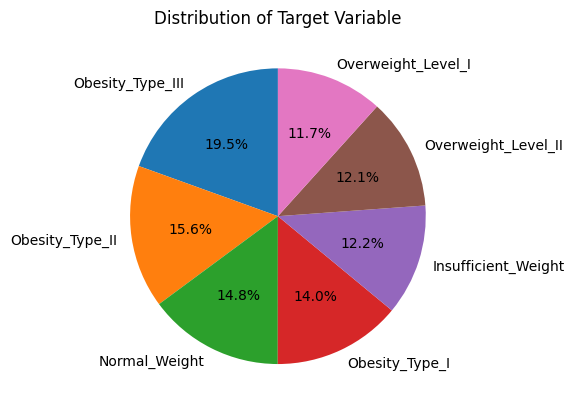

In [6]:
target_distribution = train_data['NObeyesdad'].value_counts()
plt.pie(target_distribution, labels=target_distribution.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Target Variable')
plt.show()


**Cramér's V correlation matrix**

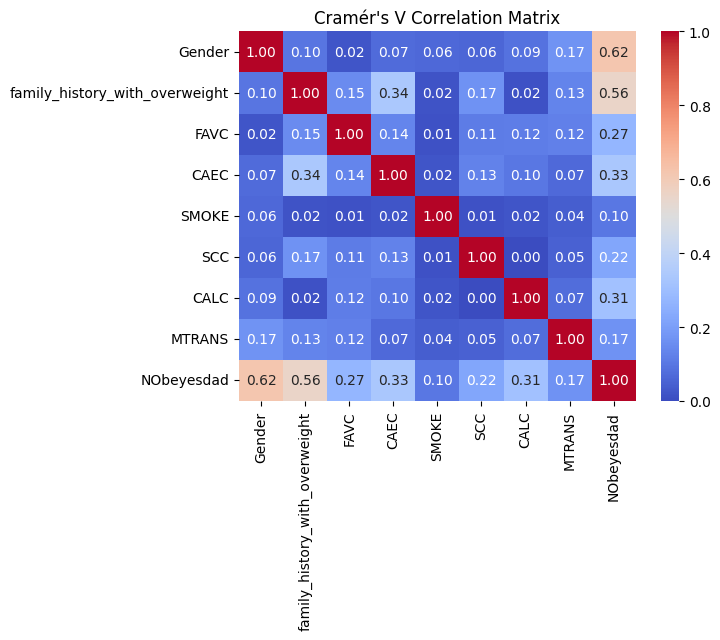

In [7]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def cramers_v_matrix(df):
    categories = df.select_dtypes(include=['object']).columns
    n = len(categories)
    v_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            confusion_matrix = pd.crosstab(df[categories[i]], df[categories[j]])
            v_matrix[i, j] = cramers_v(confusion_matrix)

    return pd.DataFrame(v_matrix, index=categories, columns=categories)

cramers_v_matrix = cramers_v_matrix(train_data)
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Cramér's V Correlation Matrix")
plt.show()

#  Data scaling

**Apply Standard Scaling to numerical features**

In [8]:
scaler = StandardScaler()
numerical_features = train_data.select_dtypes(include=['float64']).columns
train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])
test_data[numerical_features] = scaler.transform(test_data[numerical_features])


# Feature engineering


**Combine train and test sets**

In [9]:
combined_data = pd.concat([train_data, test_data], ignore_index=True)

In [10]:
le = LabelEncoder()
categorical_features = combined_data.select_dtypes(include=['object']).columns

for feature in categorical_features:
    combined_data[feature] = le.fit_transform(combined_data[feature].astype(str))



**Split back to train and test sets**

In [11]:
train_data = combined_data.iloc[:len(train_data)]
test_data = combined_data.iloc[len(train_data):]

#  Model building and training

**Split the data into features and target**

In [12]:
X = train_data.drop(['id', 'NObeyesdad'], axis=1)
y = train_data['NObeyesdad']


**Split the data into training and validation sets**

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


**Define the objective function for Optuna for XGBoost**

In [14]:
def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'num_class': len(train_data['NObeyesdad'].unique()),
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 1.0, log=True),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10)
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    model = xgb.train(params, dtrain, evals=[(dval, 'eval')], early_stopping_rounds=20, verbose_eval=False)
    y_pred = model.predict(dval)

    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

**Create the Optuna study for XGBoost**

In [15]:
study = optuna.create_study(direction='maximize', study_name='your_study_name', storage='sqlite:///your_study.db', load_if_exists=True)
study.optimize(objective, n_trials=50)
best_params = study.best_params
print(f"Best parameters: {best_params}")



Best parameters: {'lambda': 6.150424880753579e-05, 'alpha': 0.2022565237865206, 'max_depth': 6, 'eta': 0.5171327948651021, 'gamma': 0.015136404313914659, 'colsample_bytree': 0.782506369729864, 'subsample': 0.7142701778150642, 'min_child_weight': 1.9644051221419732}


**Train the final XGBoost  model with the best parameters**

In [16]:
final_params = {
    'objective': 'multi:softmax',
    'num_class': len(train_data['NObeyesdad'].unique()),
    **best_params
}
final_model = xgb.train(final_params, xgb.DMatrix(X, label=y), num_boost_round=50)


**Make predictions on the test set using XGBoost**

In [17]:
X_test = test_data.drop(['id', 'NObeyesdad'], axis=1)
dtest = xgb.DMatrix(X_test)
test_predictions = final_model.predict(dtest)



# Create the submission file

In [18]:
submission = pd.DataFrame({'id': test_data['id'], 'NObeyesdad': le.inverse_transform(test_predictions.astype(int))})
submission.to_csv('submission.csv', index=False)